### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

Part 1

In [83]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#load in data
hw_data = np.load("../../../homeworks/hw_data/hw8_data_1.npy")
print(hw_data.dtype.names)
# print([entry[0] for entry in hw_data])
ug = hw_data['u'] - hw_data['g'] #u-g
gr = hw_data['g'] - hw_data['r'] #g-r
ri = hw_data['r'] - hw_data['i'] #r-i
iz = hw_data['i'] - hw_data['z'] #i-z
redshift = hw_data['redshift']
spec = hw_data['specClass']
qso = np.where(spec=='QSO')
gal = np.where(spec=='GALAXY')
print('the number of quasars:',len(spec[qso]))
print('the number of galaxies:',len(spec[gal]))

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
the number of quasars: 7192
the number of galaxies: 42808


Part 2

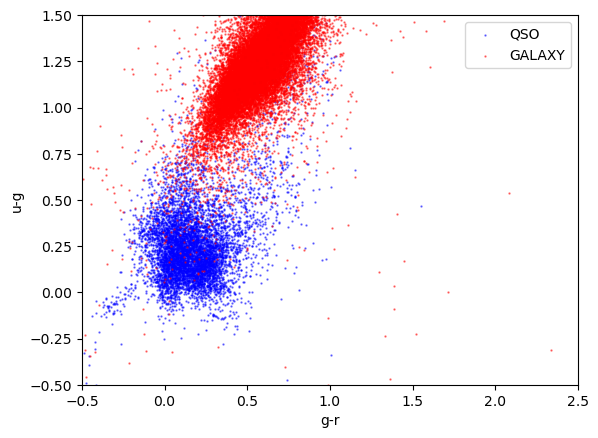

In [67]:
plt.scatter(gr[qso],ug[qso], color='blue', label='QSO', s=.5, alpha=0.5)
plt.scatter(gr[gal],ug[gal], color='red', label='GALAXY',s=.5, alpha=0.5)
plt.legend()
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('g-r')
plt.ylabel('u-g')
plt.show()

Part 3

In [84]:
from sklearn.model_selection import train_test_split

X = np.stack([ug,gr,ri,iz,redshift], axis=1) #stack
target_label = np.where(spec=='GALAXY',0,1) #0 = galaxy, 1 = qso
X_train, X_test, target_label_train, target_label_test = train_test_split(X, target_label, test_size=0.2, random_state=42)

Part 4

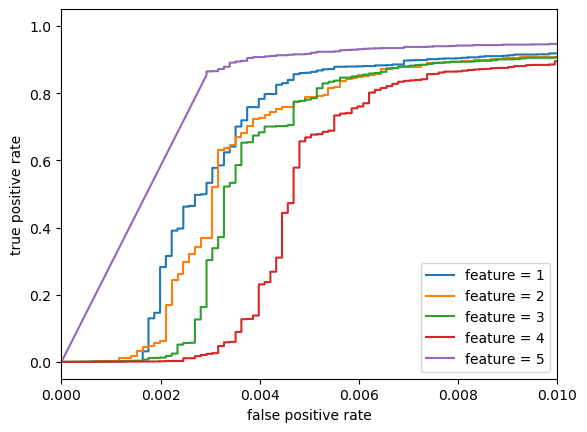

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

#loop through every column
for i in range(len(X[0,:])):
    clf = GaussianNB()
    clf.fit(X_train[:,:i+1], target_label_train)
    y_probs = clf.predict_proba(X_test[:,:i+1])[:, 1] #only for quasars
    fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    plt.plot(fpr, tpr,label=f'feature = {i+1}')
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

SRT: Which one makes classification trivial? Redshift. -1 point

Part 5

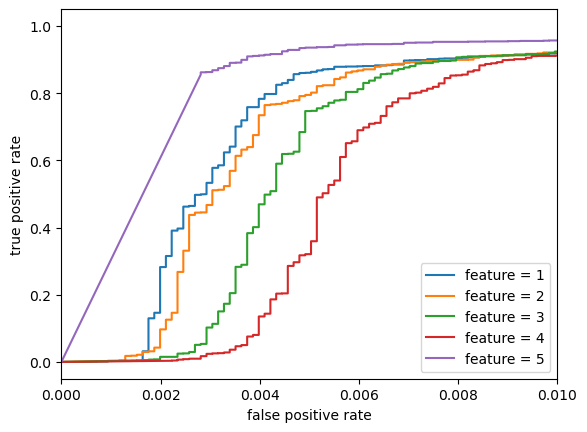

In [87]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve


for i in range(len(X[0,:])):
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train[:,:i+1], target_label_train)
    y_probs = clf.predict_proba(X_test[:,:i+1])[:, 1] #only quasars
    fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    plt.plot(fpr, tpr,label=f'feature = {i+1}')
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

Part 6

the number of components for best performance: 10


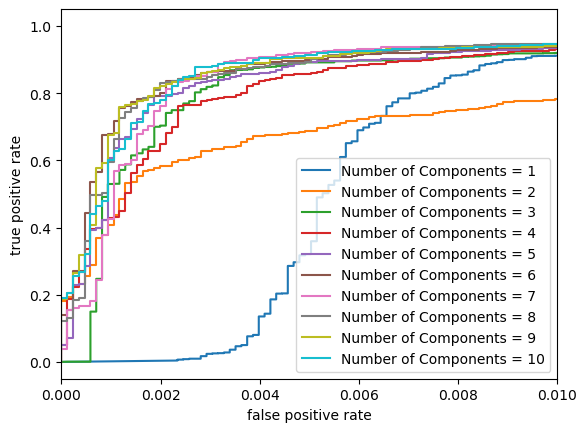

In [89]:
from astroML.classification import GMMBayes
from sklearn.metrics import roc_auc_score

auc_score_gmmbayes = []
#loop over components
for i in range(10):
    gmmb = GMMBayes(i+1)
    gmmb.fit(X_train[:,:4],target_label_train)
    y_probs = gmmb.predict_proba(X_test[:,:4])[:, 1] #only quasars

    fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
    auc_score = roc_auc_score(target_label_test, y_probs) #get area under the curve
    auc_score_gmmbayes.append(auc_score)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr,label=f'Number of Components = {i+1}')
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
print('the number of components for best performance:',np.argmax(auc_score_gmmbayes)+1)

Part 7

the number of neighbors for best performance: 95


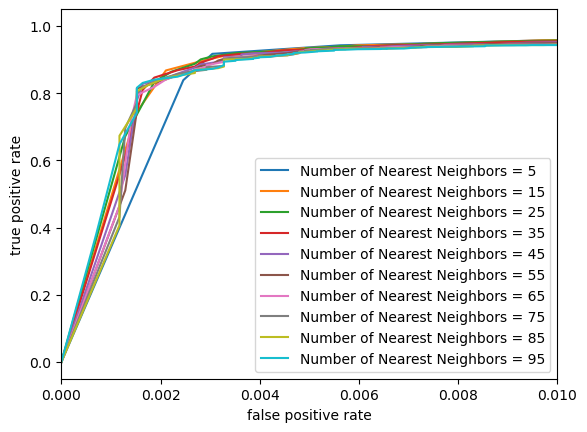

In [92]:
from sklearn.neighbors import KNeighborsClassifier
auc_score_knn = []

N = np.arange(5,100,10)

#loop of Neighbors
for i in N:
    knn = KNeighborsClassifier(i)
    knn.fit(X_train[:,:4],target_label_train)
    y_probs = knn.predict_proba(X_test[:,:4])[:, 1] #only quasars

    fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
    auc_score = roc_auc_score(target_label_test, y_probs)
    auc_score_knn.append(auc_score)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr,label=f'Number of Nearest Neighbors = {i}')
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
print('the number of neighbors for best performance:', N[np.argmax(auc_score_knn)])

Part 8

max tree depth for best performance: 6


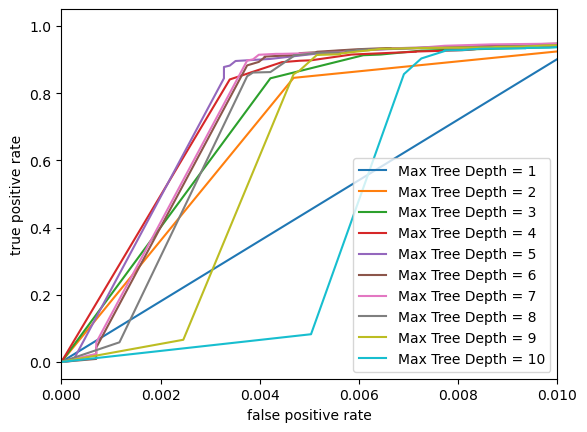

In [93]:
from sklearn.tree import DecisionTreeClassifier
auc_score_dtc = []

for i in range(10):
    clf = DecisionTreeClassifier(max_depth=i+1)
    clf.fit(X_train[:,:4],target_label_train)
    y_probs = clf.predict_proba(X_test[:,:4])[:, 1]

    fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
    auc_score = roc_auc_score(target_label_test, y_probs)
    auc_score_dtc.append(auc_score)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr,label=f'Max Tree Depth = {i+1}')
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
print('max tree depth for best performance:',np.argmax(auc_score_dtc)+1)

Part 9

GNB: 0.9744293116176894
QDA: 0.9806134035966375
gmm_bayes: 0.990784291784994
knn: 0.9922689706419516
DTC: 0.9806291993353089
KNN classifier performs best


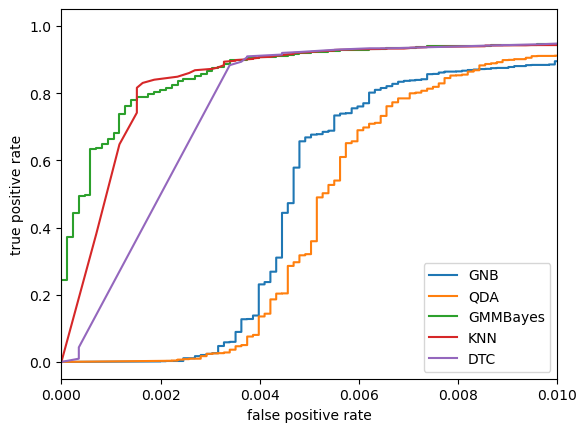

In [95]:
#using first 4 columns only!
#GNB
clf = GaussianNB()
clf.fit(X_train[:,:4], target_label_train)
y_probs = clf.predict_proba(X_test[:,:4])[:, 1]
fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
auc_score = roc_auc_score(target_label_test, y_probs)
print('GNB:',auc_score)
plt.plot(fpr, tpr, label='GNB')

#QDA
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[:,:4], target_label_train)
y_probs = clf.predict_proba(X_test[:,:4])[:, 1]
fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
auc_score = roc_auc_score(target_label_test, y_probs)
print('QDA:',auc_score)
plt.plot(fpr, tpr, label='QDA')

#GMMBayes
gmmb = GMMBayes(np.argmax(auc_score_gmmbayes)+1)
gmmb.fit(X_train[:,:4],target_label_train)
y_probs = gmmb.predict_proba(X_test[:,:4])[:, 1]
fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
auc_score = roc_auc_score(target_label_test, y_probs)
print('gmm_bayes:',auc_score)
plt.plot(fpr, tpr, label='GMMBayes')

#KNN
knn = KNeighborsClassifier(N[np.argmax(auc_score_knn)])
knn.fit(X_train[:,:4],target_label_train)
y_probs = knn.predict_proba(X_test[:,:4])[:, 1]
fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
auc_score = roc_auc_score(target_label_test, y_probs)
print('knn:',auc_score)
plt.plot(fpr, tpr, label='KNN')

#DTC
clf = DecisionTreeClassifier(max_depth=np.argmax(auc_score_dtc)+1)
clf.fit(X_train[:,:4],target_label_train)
y_probs = clf.predict_proba(X_test[:,:4])[:, 1]
fpr, tpr, thresh = roc_curve(target_label_test, y_probs)
auc_score = roc_auc_score(target_label_test, y_probs)
print('DTC:',auc_score)
plt.plot(fpr, tpr, label='DTC')
plt.xlim(0,0.01)
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

print("KNN classifier performs best")

Part 10

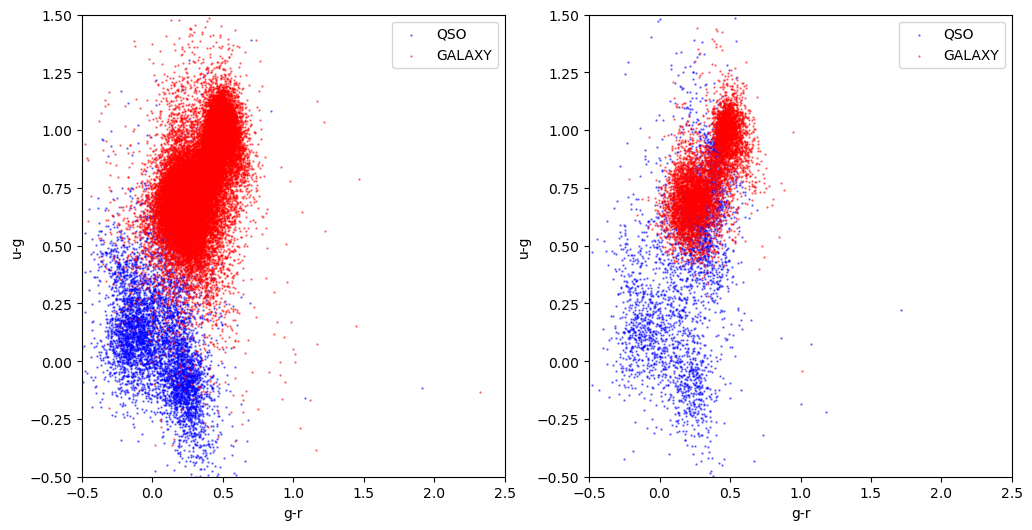

In [97]:
#colors of training data
ug_train = X_train[:,0]-X_train[:,1]
gr_train = X_train[:,1]-X_train[:,2]
#labels of training data
qso = target_label_train.nonzero()[0]
gal = (target_label_train == 0).nonzero()[0]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6))

ax1.scatter(gr_train[qso],ug_train[qso], color='blue', label='QSO', s=.5, alpha=0.5)
ax1.scatter(gr_train[gal],ug_train[gal], color='red', label='GALAXY',s=.5, alpha=0.5)
ax1.legend()
ax1.set_xlim(-0.5,2.5)
ax1.set_ylim(-0.5,1.5)
ax1.set_xlabel('g-r')
ax1.set_ylabel('u-g')


#KNN worked best
knn = KNeighborsClassifier(N[np.argmax(auc_score_knn)])
knn.fit(X_train[:,:4],target_label_train)
y_probs = knn.predict_proba(X_test[:,:4])[:, 1]
ug_test = X_test[:,0]-X_test[:,1]
gr_test = X_test[:,1]-X_test[:,2]
#qso prob > 0
qso = np.where(y_probs>0)
gal = np.where(y_probs==0)
ax2.scatter(gr_test[qso],ug_test[qso], color='blue', label='QSO', s=.5, alpha=0.5)
ax2.scatter(gr_test[gal],ug_test[gal], color='red', label='GALAXY',s=.5, alpha=0.5)
ax2.legend()
ax2.set_xlim(-0.5,2.5)
ax2.set_ylim(-0.5,1.5)
ax2.set_xlabel('g-r')
ax2.set_ylabel('u-g')
plt.show()

SRT: You make `ug_test` and `gr_test` out of differences in `X_test`, but `X_test` already has the colors. No need for further subtraction. -1 point

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

Part 1

In [76]:
hw_data_reduced = hw_data[::10] #take every 10th row
ug = hw_data_reduced['u'] - hw_data_reduced['g']
gr = hw_data_reduced['g'] - hw_data_reduced['r']
ri = hw_data_reduced['r'] - hw_data_reduced['i']
iz = hw_data_reduced['i'] - hw_data_reduced['z']

redshift = hw_data_reduced['redshift']
spec = hw_data_reduced['specClass']

Part 2

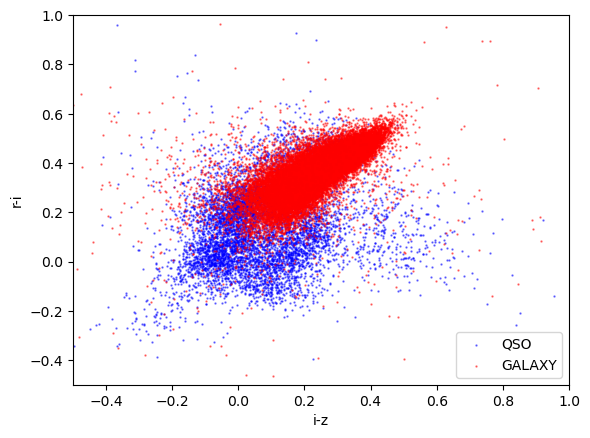

In [98]:
qso = np.where(spec=='QSO')
gal = np.where(spec=='GALAXY')

plt.scatter(iz[qso],ri[qso], color='blue', label='QSO', s=.5, alpha=0.5)
plt.scatter(iz[gal],ri[gal], color='red', label='GALAXY',s=.5, alpha=0.5)
plt.legend()
plt.xlim(-0.5,1)
plt.ylim(-0.5,1)
plt.xlabel('i-z')
plt.ylabel('r-i')
plt.show()

Part 3

In [99]:
X = np.stack([ri,iz], axis=1) #stack data
target_label = np.where(spec=='GALAXY',0,1) #gal = 0, qso = 1
X_train, X_test, y_train, y_test = train_test_split(X, target_label, test_size=0.2, random_state=42)

Part 4

In [100]:
from sklearn import preprocessing

#scale data for dnn
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)
Xscaled = preprocessing.scale(X)

Part 5

Text(0, 0.5, 'true positive rate')

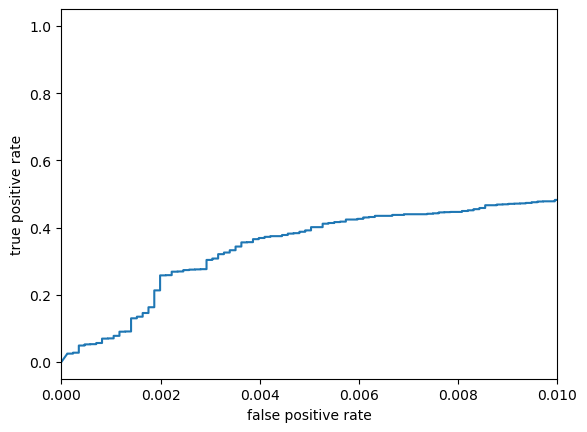

In [101]:
from sklearn.neural_network import MLPRegressor

#use MLPRegressor, ReLU and stochastic gradient descent
clf = MLPRegressor(activation='relu',solver='sgd', 
                   hidden_layer_sizes=(5,2), 
                   random_state=42, max_iter=1000)
#fit data
clf.fit(Xtrain_scaled, y_train)
#predict
ypred = clf.predict(Xtest_scaled)
#roc curve
fpr, tpr, thresh = roc_curve(y_test, ypred)
plt.plot(fpr, tpr)
plt.xlim(0,0.01)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')


SRT: Ah, you used the MLP Regressor instead of the Classifer. Deducting a point for that, but no further deducation below. -1 point

Part 6

In [ ]:
from sklearn.model_selection import GridSearchCV

#set param grid
param_grid = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}

#search over params and fit
grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(Xtrain_scaled, y_train)

print("Best parameters found by GridSearchCV:")
print(grid.best_params_)

print(f"classification score: {grid.best_score_:.4f}")


Best parameters found by GridSearchCV:
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}
Best CV score (mean test score): 0.6100


Part 7

Text(0, 0.5, 'true positive rate')

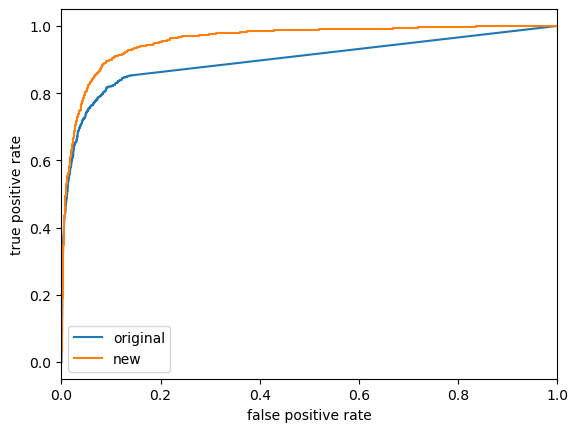

In [103]:
#using best params from 6
clf_new = MLPRegressor(activation='tanh',solver='lbfgs', 
                   hidden_layer_sizes=(5,5), 
                   random_state=42, max_iter=1000)
clf_new.fit(Xtrain_scaled, y_train)
ypred_new = clf_new.predict(Xtest_scaled)
fpr_new, tpr_new, thresh_new = roc_curve(y_test, ypred_new)

plt.plot(fpr, tpr, label='original')
plt.plot(fpr_new, tpr_new, label='new')
plt.legend()
plt.xlim(0,1)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

SRT: Good work, Azeem.

47/50